<a href="https://colab.research.google.com/github/Yash0330/stylegan-encoder/blob/master/Explained_and_Experimented_with_StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Generate Faces With StyleGAN

Hi, My name is Yashwanth M welcome to this tutorial on generating and messsing around with Faces uing StyleGAN.

# Setting thigs up

StyleGAN is a massive model that can take weeks to train. So for this tutorial, we're going to use a pretrained model that Nvidia open-sourced. You can find the official implementation [here](https://github.com/NVlabs/stylegan).

But here, we're going to use a version of that repo that I forked and modified specifically.

So first, let's clone the repo and move into it.

In [0]:
! git clone https://github.com/Yash0330/stylegan-encoder
import os
os.chdir("stylegan-encoder")

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 59 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (59/59), done.


In [0]:
!mkdir raw_images
!mkdir aligned_images
!mkdir generated_images
!mkdir latent_representations

In [0]:
!python align_images.py raw_images/ aligned_images/

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
!python encode_images.py aligned_images/ generated_images/ latent_representations/

Streaming output truncated to the last 5000 lines.
leonardo_01 Loss: 0.79:  50% 505/1000 [03:06<02:59,  2.76it/s]
leonardo_01 Loss: 0.78:  50% 505/1000 [03:06<02:59,  2.76it/s]
leonardo_01 Loss: 0.78:  51% 506/1000 [03:06<02:59,  2.76it/s]
leonardo_01 Loss: 0.77:  51% 506/1000 [03:06<02:59,  2.76it/s]
leonardo_01 Loss: 0.77:  51% 507/1000 [03:06<02:58,  2.77it/s]
leonardo_01 Loss: 0.78:  51% 507/1000 [03:07<02:58,  2.77it/s]
leonardo_01 Loss: 0.78:  51% 508/1000 [03:07<02:57,  2.78it/s]
leonardo_01 Loss: 0.77:  51% 508/1000 [03:07<02:57,  2.78it/s]
leonardo_01 Loss: 0.77:  51% 509/1000 [03:07<02:57,  2.77it/s]
leonardo_01 Loss: 0.78:  51% 509/1000 [03:08<02:57,  2.77it/s]
leonardo_01 Loss: 0.78:  51% 510/1000 [03:08<02:56,  2.78it/s]
leonardo_01 Loss: 0.78:  51% 510/1000 [03:08<02:56,  2.78it/s]
leonardo_01 Loss: 0.78:  51% 511/1000 [03:08<02:56,  2.77it/s]
leonardo_01 Loss: 0.80:  51% 511/1000 [03:08<02:56,  2.77it/s]
leonardo_01 Loss: 0.80:  51% 512/1000 [03:08<02:56,  2.77it/s]
leon

In [0]:
!pip install tensorflow-gpu==1.14

     |████████████████████████████████| 377.0MB 48kB/s 
     |████████████████████████████████| 3.2MB 57.2MB/s 
     |████████████████████████████████| 491kB 52.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 1.14.0 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 1.14.0 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


Next, we need to import a few required libraries. You can pretty much leave this part alone, but be sure to run it.

In [0]:
import os
import pickle
import PIL.Image
import numpy as np
import dnnlib
import dnnlib.tflib as tflib
import config
from encoder.generator_model import Generator

import matplotlib.pyplot as plt
%matplotlib inline

Like I mentioned, we're going to use a pretrained StyleGAN, which was trained on the [FFHQ dataset](https://www.github.com/NVlabs/ffhq-dataset). This code block downloads the weights and initializes the network to make it easy for us to play around with the model via a high-level interface.

In [0]:
URL_FFHQ = 'https://s3-us-west-2.amazonaws.com/nanonets/blogs/karras2019stylegan-ffhq-1024x1024.pkl'

tflib.init_tf()
with dnnlib.util.open_url(URL_FFHQ, cache_dir=config.cache_dir) as f:
    generator_network, discriminator_network, Gs = pickle.load(f)

generator = Generator(Gs, batch_size=1, randomize_noise=False)

We'll also define these helper functions. It may not seem intuitive now, but these functions will make it really easy to iterate quickly later on.

In [0]:
def generate_image(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]
    img = PIL.Image.fromarray(img_array, 'RGB')
    #return img
    return img.resize((256, 256))

def move_and_show(latent_vector, direction, coeffs):
    fig,ax = plt.subplots(1, len(coeffs), figsize=(15, 10), dpi=80)
    for i, coeff in enumerate(coeffs):
        new_latent_vector = latent_vector.copy()
        new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
        ax[i].imshow(generate_image(new_latent_vector))
        ax[i].set_title('Coeff: %0.1f' % coeff)
    [x.axis('off') for x in ax]
    plt.show()

In [0]:
# Loading already learned representations
yash = np.load('latent_representations/yash_01.npy')
modi = np.load('latent_representations/modi_01.npy')
trump = np.load('latent_representations/donald_trump_01.npy')
robert = np.load('latent_representations/Robert-Downey-Jr_01.npy')
jason = np.load('latent_representations/Jason-Statham_01.npy')
tom_cruise = np.load('latent_representations/Tom_cruise_01.npy')
jennifer = np.load('latent_representations/jennifer_01.npy')
leonardo = np.load('latent_representations/leonardo_01.npy')
ronaldo = np.load('latent_representations/ronaldo_01.npy')
will_smith = np.load('latent_representations/will_smith_01.npy')

# Loading already learned latent directions
smile_direction = np.load('ffhq_dataset/latent_directions/smile.npy')
gender_direction = np.load('ffhq_dataset/latent_directions/gender.npy')
age_direction = np.load('ffhq_dataset/latent_directions/age.npy')

If you want to play around with your own images, go ahead! All you have to do is make sure you have the right folders set up, then upload your face images to the 'raw_images' folder (without quotes) and these scripts by uncommenting the appropriate lines.

In [0]:
# First, set up the required folders

#os.mkdir('raw_images')
#os.mkdir('aligned_images')
#os.mkdir('generated_images')

# Then, run these scripts

# 1) Extract and align faces from images
#!python align_images.py raw_images/ aligned_images/

# 2) Find latent representation of aligned images
#!python encode_images.py aligned_images/ generated_images/ latent_representations/

# Character Transformations

Using the latent representation of any character along with the learned latent directions, you can adjust three traits of any charcter: smile, age, and gender. This is done via the `move_and_show()` function, which takes three arguments: a latent vector, a latent direction, and an array of coefficients. It then performs the following computation:


$$ \text{new latent vector} = \text{latent vector} + (\text{coefficient} * \text{latent direction} )$$


The new latent vectors are passed through the StyleGAN genertor, and the resulting images are plotted. You can refer back to the previous section to go through the implementation of `move_and_show()`.

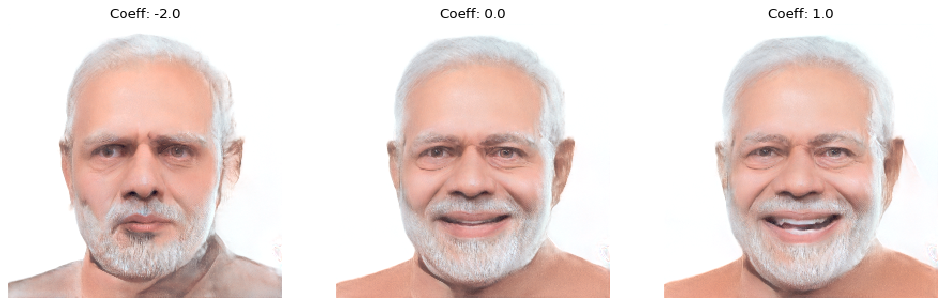

In [0]:
move_and_show(modi, smile_direction, [-2, 0, 1])

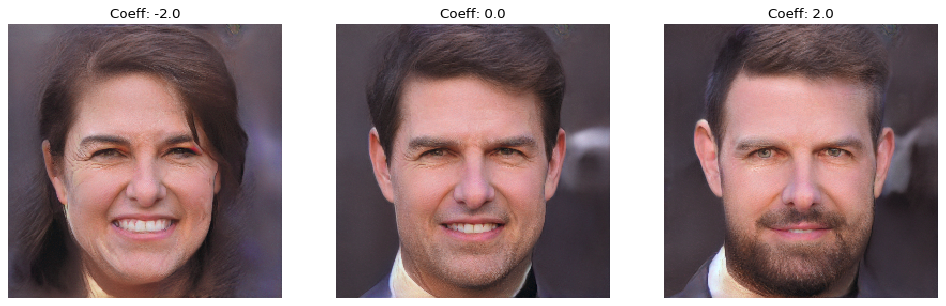

In [0]:
move_and_show(tom_cruise, gender_direction, [-2, 0, 2])

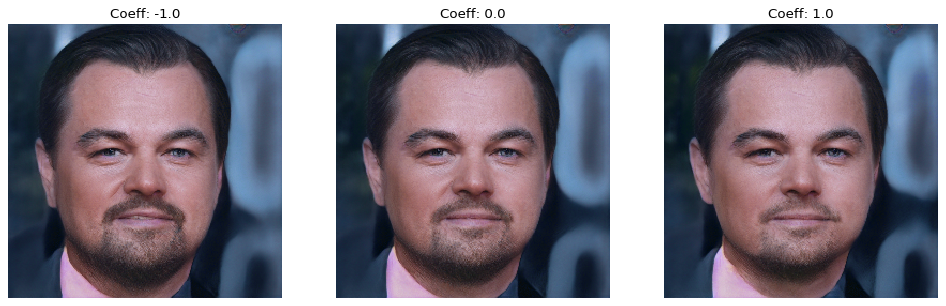

In [0]:
  move_and_show(leonardo, age_direction, [-1, 0, 1])

#Character Fusion

We can also try mixing characters together to find an "average" of the two. The easiest way to do this is to simply take an average of the two latent vectors and generate an image using the average latent vector. You can also adjust how much of each character you want by changing `alpha`.


Now for the moment of truth -- Let's see what the future protector of the realm will look like!

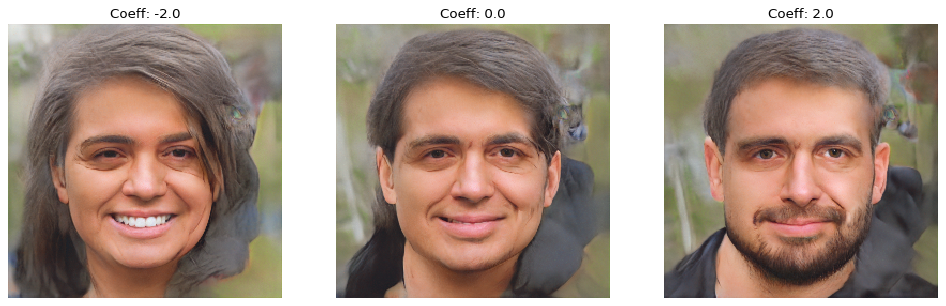

In [0]:
alpha = 0.5

mix = (((alpha)*trump)+((1-alpha)*yash))

move_and_show(mix, gender_direction, [-2, 0, 2])

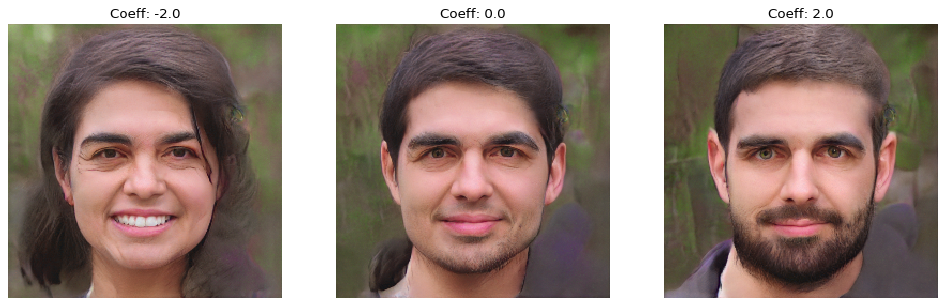

In [0]:
alpha = 0.5

mix = (((alpha)*tom_cruise)+((1-alpha)*yash))

move_and_show(mix, gender_direction, [-2, 0, 2])

Note that above, you basically created a new character, so can save that latent and do the age, gender, and smile transforms as shown above.

The second, and perhaps more interesting way to fuse characters i through Nvidia's style mixing technique.The code below is a modification of Nvidia's style mixing implementation.

In [0]:
def draw_style_mixing_figure(png, Gs, w, h, src_dlatents, dst_dlatents, style_ranges):
    print(png)
    #src_dlatents = Gs.components.mapping.run(src_latents, None) # [seed, layer, component]
    #dst_dlatents = Gs.components.mapping.run(dst_latents, None)
    src_images = Gs.components.synthesis.run(src_dlatents, randomize_noise=False, **synthesis_kwargs)
    dst_images = Gs.components.synthesis.run(dst_dlatents, randomize_noise=False, **synthesis_kwargs)

    canvas = PIL.Image.new('RGB', (w * (len(src_dlatents) + 1), h * (len(dst_dlatents) + 1)), 'white')
    for col, src_image in enumerate(list(src_images)):
        canvas.paste(PIL.Image.fromarray(src_image, 'RGB'), ((col + 1) * w, 0))
    for row, dst_image in enumerate(list(dst_images)):
        canvas.paste(PIL.Image.fromarray(dst_image, 'RGB'), (0, (row + 1) * h))
        row_dlatents = np.stack([dst_dlatents[row]] * len(src_dlatents))
        row_dlatents[:, style_ranges[row]] = src_dlatents[:, style_ranges[row]]
        row_images = Gs.components.synthesis.run(row_dlatents, randomize_noise=False, **synthesis_kwargs)
        for col, image in enumerate(list(row_images)):
            canvas.paste(PIL.Image.fromarray(image, 'RGB'), ((col + 1) * w, (row + 1) * h))
    canvas.save(png)
    return canvas.resize((512,512))

style-mixing.png


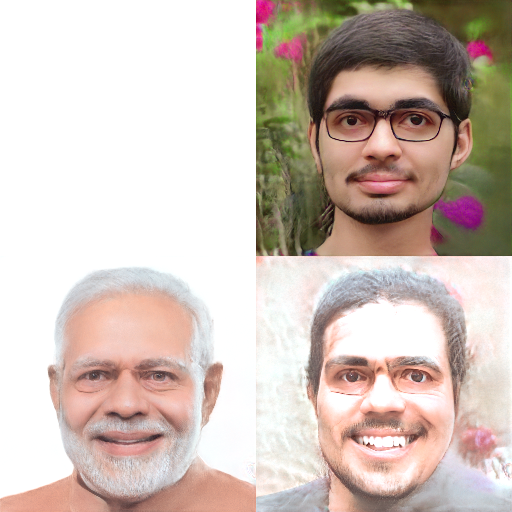

In [0]:
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)
_Gs_cache = dict()

draw_style_mixing_figure('style-mixing.png', Gs, w=1024, h=1024, src_dlatents=yash.reshape((1, 18, 512)), dst_dlatents=modi.reshape((1, 18, 512)), style_ranges=[range(6,14)])

Surprisingly, I found the simple averaging method to produce better results, and I'm not sure why that's the case. I'd encourage you to keep trying Nvidia's style mixing method with different paramets, since you might get some really cool results.

# Interpolation Videos


This secion will prduce one of the most exciting reults -- GAN interpolation videos. These videos perform smooth transitions between various images, which you'll only understand if you watch one yourself. So to make your own, start by tweaking these parameters to your preferences (note: this can increase the time it takes to generate a video).

In [0]:
duration_sec = 5.0
smoothing_sec = 1.0
mp4_fps = 20
num_frames = int(np.rint(duration_sec * mp4_fps))

Next, we'll define two helper functions like the ones from the start of this notebook. Except, these will reurn image arrays instead.

In [0]:
def generate_image_for_video(latent_vector):
    latent_vector = latent_vector.reshape((1, 18, 512))
    generator.set_dlatents(latent_vector)
    img_array = generator.generate_images()[0]

    return img_array
  
  
def move_for_video(latent_vector, direction, coeff):
  
  new_latent_vector = latent_vector.copy()
  new_latent_vector[:8] = (latent_vector + coeff*direction)[:8]
  
  img_array = generate_image(new_latent_vector)
  
  return img_array

Finally, run this code block to generate cool videos. The results will be saved under the reults folder. Follow the comments to generate different kinds of videos, and enjoy!

In [0]:
# If you're interpolating between two characters, set these characters here
char1 = yash
char2 = tom_cruise

# This creates an nd array that stores all the image frames fot cross-character interpolation
src_images = np.stack(generate_image_for_video((0.01*alpha*char2)+((1-(0.01*alpha))*char1)) for alpha in range (100))


# Uncomment the next line if you want to do a character transforation video, and choose the arguments as per your requirement
#src_images = np.stack(move_for_video(dany_meme, smile_direction, (0.02*alpha)) for alpha in range (-100,100))


def make_frame(t):
    frame_idx = int(np.clip(np.round(t * mp4_fps), 0, num_frames - 1))
    src_image = src_images[frame_idx]
    return np.array(src_image)

# Generate video.
import moviepy.editor
mp4_file = 'interpolate.mp4'
mp4_codec = 'libx264'
mp4_bitrate = '5M'

video_clip = moviepy.editor.VideoClip(make_frame, duration=duration_sec)
video_clip.write_videofile(mp4_file, fps=mp4_fps, codec=mp4_codec, bitrate=mp4_bitrate)

[MoviePy] >>>> Building video interpolate.mp4
[MoviePy] Writing video interpolate.mp4



 99%|█████████▉| 100/101 [00:06<00:00,  7.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: interpolate.mp4 



In [0]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('interpolate.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)